In [1]:
%%capture
!pip install pythtb --upgrade

In [2]:
from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pylab import *

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import itertools

Comenzamos con la construcción de una celda triangular (red de Kagome), que será la base para nuestro análisis en este trabajo.

In [4]:
a= 1
h= 1.0
a_1 = array( [1*a, 0, 0] )
a_2 = array( [(1/2)*a, (np.sqrt(3)/2)*a, 0] )
a_3 = array( [0, 0, h] )
lat = [a_1, a_2, a_3]

In [5]:
orb = array( [ [0,0,0],[0,1/2,0],[1/2,0,0] ] )

In [6]:
#Construcción de la celda triangular
N         = 15 #número de celdas base 
infCelda  = {}
celda     = 0
ind       = 0
sitios    = [] 

for n2 in range(N) :
  for n1 in range(N-n2):
    sitios.append( orb[0]+array([n1,n2,0]) )
    sitios.append( orb[1]+array([n1,n2,0]) )
    sitios.append( orb[2]+array([n1,n2,0]) )
    infCelda[celda] = array( [ind,ind+1,ind+2] )
    celda+=1
    ind+=3

sitios = array(sitios)
print(shape(sitios))
vec = array([a_1,a_2,a_3])
X,Y,Z = dot(sitios, vec).T

(360, 3)


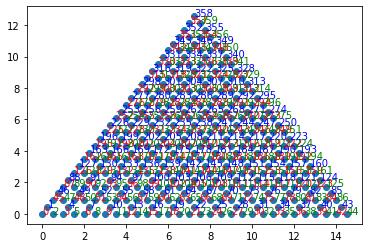

In [7]:
colores = ["r", "b", "g"]
scatter(X,Y) #graficamos nuestra supercelda
for n in range(len(X)):
  text(X[n],Y[n], "{0}".format(n), color=colores[mod(n,3)])

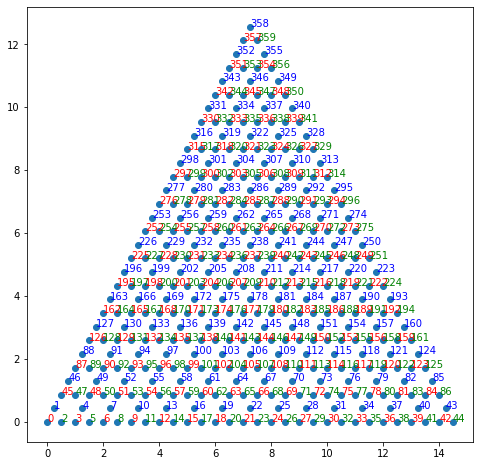

In [40]:
fig,ax = plt.subplots(figsize=(8,8)) #agrandamos la imagen
colores = ["r", "b", "g"] #cada color indica un átomo diferente de cada celda unitaria
ax.scatter(X,Y)
for n in range(len(X)):
  ax.text(X[n],Y[n], "{0}".format(n), color=colores[mod(n,3)])

In [9]:
nn = {}
for todos in range(len(X)):

    UnSitio     = array([X[todos],Y[todos],Z[todos]])
    DataUnSitio = kron(ones(360),UnSitio)
    DataUnSitio = DataUnSitio.reshape(360,3)

    Dif = DataUnSitio - array([X,Y,Z]).T
    normas = []
    for n in range(len(Dif)):
        norm = sqrt(dot(Dif[n],Dif[n]))
        normas.append(norm)
    normas  = array(normas)
    logical = normas<0.6

    nn[todos] = delete( logical.nonzero()[0], \
        where(logical.nonzero()[0] == todos) )

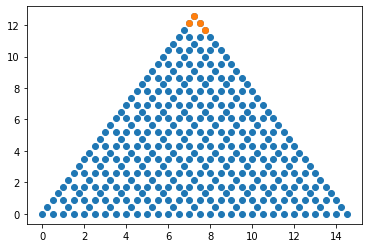

In [10]:
scatter(X,Y)
scatter(X[logical],Y[logical])

In [11]:
lat = [N*a_1, N*a_2, a_3]
orb = sitios
nSitios = len(orb)
print(lat)

[array([15,  0,  0]), array([ 7.5       , 12.99038106,  0.        ]), array([0., 0., 1.])]


In [12]:
sitios[10]

array([3. , 0.5, 0. ])

In [13]:
KagomePrisma = tb_model( 3,3,lat, orb )

t_a = -1.0 #valor del hopping intracelda de A a B
t_b = -2.4 #valor del hopping intracelda de B a A
t_z = -1   #valor del hopping intercelda

# Defino el valor de los hoppings en el plano xy


for nCelda in infCelda.keys():
    for n in infCelda[nCelda]:
        for vecino  in nn[n]:
            # en qué celda está 'n'y en qué celda está 'vecinos'
            if (vecino in infCelda[nCelda]):
                try:
                    KagomePrisma.set_hop(t_a, n, vecino, [0,0,0])
                except:
                    pass
            else: 
                try:
                    KagomePrisma.set_hop(t_b, n, vecino, [0,0, 0])
                    KagomePrisma.set_hop(t_z, n, vecino, [0,0, 1])
                    KagomePrisma.set_hop(t_z, n, vecino, [0,0,-1])
                except:
                    pass

In [14]:
# Lista de puntos que definen el path 
path  = [[0,0,-1/2],[0,0,1/2]]

k_vec, k_dist, k_node = KagomePrisma.k_path(path,201,report=False)

# Obtengo los eigenvalores para cada punto (kx,ky,kz) de k_vec
evals, evec = KagomePrisma.solve_all(k_vec,eig_vectors=True)

print(np.shape(evals))


(360, 201)


A continuación se presenta la construcción de la estructura de bandas.

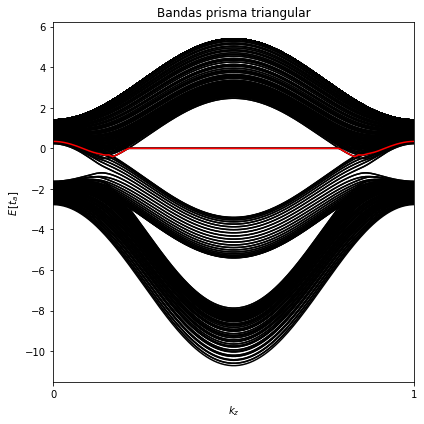

In [42]:
fig, ax = plt.subplots(figsize=(6,6))

for n in range(nSitios):
  ax.plot(k_dist,evals[n],'-',c='black',zorder=2)

ax.set_xticks(k_node)
ax.set_xlim(0,1)
ax.set_title("Bandas prisma triangular")
ax.set_xlabel(r"$k_z$")
ax.set_ylabel(r"$E\,[t_a]$")
ax.set_yticks([-10, -8, -6, -4, -2, 0, 2, 4, 6])

ax.plot(k_dist, evals[nSitios//2-47], 'r-', zorder=2) #podemos observar que para
#los valores de -45, -46 y -47 la línea roja en el diagrama permanece 
#prácticamente en el mismo valor de energía, por lo que decimos que en nuestro 
#estudio de las bandas aparecen 3 estados degenerados para la banda plana.

fig.tight_layout()
fig.savefig("BandasPrisma.pdf")

In [16]:
# Los  estados que nos interesan (es decir, los de los bordes)
# son los nSitios//2-45, nSitios//2-46, nSitios//2-47 
# de forma análoga los podemos llamar las bandas con 
# dichos índices.
# Elegimos el k_z = 0.5 en unidades del espacio recíproco (2pi/a),
# el índice de k_z es el 100, en el caso de 201 puntos k

# Obtenemos la densidad de probabilidad de estos 3 estados antes mencionados.
prob = (  real( conj(evec[nSitios//2-45][100])*evec[nSitios//2-45][100] )
         +real( conj(evec[nSitios//2-46][100])*evec[nSitios//2-46][100] )
         +real( conj(evec[nSitios//2-47][100])*evec[nSitios//2-47][100] ) )/3
# prob = real( conj(evec[nSitios//2][100])*evec[nSitios//2][100] )
print(min(prob),max(prob))

2.594615107210006e-19 0.2997874120620183


In [17]:
lat    = array([a_1,a_2,a_3])
sitios = KagomePrisma.get_orb()
coord = dot( sitios,lat )
xKagome = coord.T[0]
yKagome = coord.T[1]

In [18]:
dot( sitios[10], lat)

array([3.25     , 0.4330127, 0.       ])

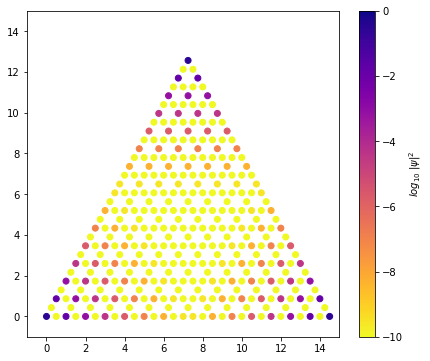

In [19]:
fig,ax = plt.subplots(figsize=(7,6))
colores = ["r", "b", "g"]
triang = ax.scatter(xKagome,yKagome,c=log10(prob),cmap=cm.plasma_r,vmin=-10,vmax=0)
ax.set_xlim(-1,15)
ax.set_ylim(-1,15)
plt.colorbar(triang,ax=ax,label="$log_{10}\;|\psi|^2$") #con esto obtenemos
#una gráfica de la densidad de probabilidad de que los estados se encuentren localizados
#en la supercelda anteriormente construida, observamos que los estados de interés
#se encuentran en los bordes de la celda.

#for n in range(len(X)):
#  ax.text(X[n],Y[n], "{0}".format(n), color=colores[mod(n,3)])

In [20]:
evals[nSitios//2-47][100]
#Coeficiente que multiplica a la función localizada en el sitio 100, por lo que ese coeficiente
#al cuadrado nos va a decir la probabilidad de encontrarlo en el 100.
#evec[nSitios//2-45][100]
#colores = ["r", "g", "b"]
#scatter(X,Y)
#for band in range():
#  text(X[n],Y[n], "{0}".format(n), color=colores[mod(n,3)])

-1.4377581220317788e-09

In [21]:
7.188798048856044e-10 #eval nSitios//2-45 valor 100 para k=0.5
7.188786997970468e-10 #eval nSitios//2-46 valor 100 para k=0.5
-1.437759375483958e-09 #eval nSitios//2-47 valor 100 para k=0.5

-1.437759375483958e-09

A continuación se desglosa el cálculo del índice de participación inversa (IPR).

In [23]:
# Lista de puntos que definen el path 
path  = [[0,0,-1/2],[0,0,1/2]]
k_vec, k_dist, k_node = KagomePrisma.k_path(path,201,report=False)
# Obtengo los eigenvalores para cada punto (kx,ky,kz) de k_vec
evals,U = KagomePrisma.solve_all(k_vec,eig_vectors=True)

print(np.shape(evals))


#Necesitaremos de los eigenvalores.
nbands, nkpts, nsites = shape(U)
IPR = []
for band in range(nbands):
  IPRband= []
  for nk in range(nkpts):
    eigenvector = U [band,nk]
    suma2 = vdot (eigenvector , eigenvector)
    suma4 = vdot (eigenvector*eigenvector , eigenvector*eigenvector)
    IPRband.append( real (suma4/suma2) ) 
  IPR.append(IPRband)
IPR = array(IPR)
print(shape(IPR))

(360, 201)
(360, 201)


In [24]:
print ( "IPR.máx", IPR.max() )
print("IPR.min",IPR.min())

IPR.máx 0.4065929041338116
IPR.min 0.004359045188037853


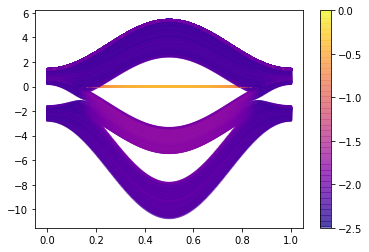

In [25]:
fig,ax = plt.subplots()
for band in range(nbands):
  grafica = ax.scatter (k_dist, evals[band], c=log10(IPR[band]),s=3,cmap=cm.plasma, vmin=-2.5, vmax=0,alpha=0.5)
fig.colorbar(grafica)
fig.savefig("IPR.png") #gráfica de IPR

In [26]:
numcells = int( len(X)/3 )
print(numcells)
print(len(infCelda))

120
120


In [27]:
Kagome= tb_model(3,3,lat,orb)

In [28]:
#Parámetros
t_a= -1.0
t_b= -2.4
t_z= -1.0
k_x= (4*np.pi/(3*a))
k_y= 0
k_w= np.arccos((t_a-t_b)/(2*t_z))

In [29]:
#Defino el valor de los hoppings en el plano xy
Kagome.set_hop(t_a,0,1,[0,0,0])
Kagome.set_hop(t_a,0,2,[0,0,0])
Kagome.set_hop(t_a,2,1,[0,0,0])
Kagome.set_hop(t_b,1,0,[0,1,0])
Kagome.set_hop(t_b,2,0,[1,0,0])
Kagome.set_hop(t_b,1,2,[-1,1,0])
#Defino el valor de los hopping en el eje z 
Kagome.set_hop(t_z,2,0,[1,0,-1])
Kagome.set_hop(t_z,2,0,[1,0,1])
Kagome.set_hop(t_z,1,0,[0,1,-1])
Kagome.set_hop(t_z,1,0,[0,1,1])
Kagome.set_hop(t_z,1,2,[-1,1,-1])
Kagome.set_hop(t_z,1,2,[-1,1,1])

In [30]:
Ek,U = Kagome.solve_all(k_vec,eig_vectors=True)

In [31]:
shape(Ek)

(360, 201)

In [32]:
#IPR
#IPR es la integral sobre el cuadrado de la densidad en algún espacio.
#Los estados localizados y deslocalizados (extendidos) corresponden a estados
#aislantes y metálicos respectivamente.
#Los valores de IPR cercanos a cero corresponden a estados deslocalizados,
#los valores cercanos a uno corresponden a estados localizados.

In [33]:
#Necesitaremos de los eigenvalores.
nbands, nkpts, nsites = shape(U)
IPR = []
for band in range(nbands):
  IPRband= []
  for nk in range(nkpts):
    eigenvector = U [band,nk]
    suma2 = vdot (eigenvector , eigenvector)
    suma4 = vdot (eigenvector*eigenvector , eigenvector*eigenvector)
    IPRband.append( real (suma4/suma2) ) 
  IPR.append(IPRband)
IPR = array(IPR)
print(shape(IPR))

(360, 201)


In [34]:
print ( "IPR.máx", IPR.max() )
print("IPR.min",IPR.min())


IPR.máx 1.0
IPR.min 0.333333333333333


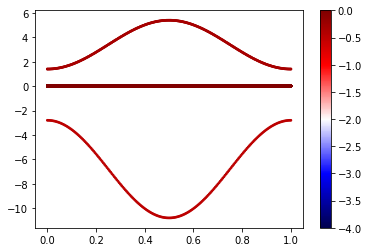

In [35]:
fig,ax = plt.subplots()
for band in range(nbands):
  grafica = ax.scatter (k_dist, Ek[band], c=log10(IPR[band]),s=3,cmap=cm.seismic, vmin=-4, vmax=0)
fig.colorbar(grafica)
fig.savefig("IPR.png")

In [36]:
#Construcción de gráfica:
#Tomando un valor de k y el eigenvalor que queda en los estados localizados.
#Hacer la gráfica de ese eigenestado.
#Dado que son 3 estados (corresponde a 3 eigenvectores), se hacen por separado primero.

In [37]:
path=[ [ 0, 0, -1/2], [0, 0, 1/2] ]
(k_vec,k_dist, k_node)=KagomePrisma.k_path(path,201, report=True)
evals=KagomePrisma.solve_all(k_vec)
print(evals)

----- k_path report begin ----------
real-space lattice vectors
 [[15.       0.       0.     ]
 [ 7.5     12.99038  0.     ]
 [ 0.       0.       1.     ]]
k-space metric tensor
 [[ 0.00593 -0.00296  0.     ]
 [-0.00296  0.00593  0.     ]
 [ 0.       0.       1.     ]]
internal coordinates of nodes
 [[ 0.   0.  -0.5]
 [ 0.   0.   0.5]]
reciprocal-space lattice vectors
 [[ 0.06667 -0.03849  0.     ]
 [ 0.       0.07698  0.     ]
 [ 0.       0.       1.     ]]
cartesian coordinates of nodes
 [[ 0.   0.  -0.5]
 [ 0.   0.   0.5]]
list of segments:
  length =     1.0  from  [ 0.   0.  -0.5]  to  [0.  0.  0.5]
node distance list: [0. 1.]
node index list:    [  0 200]
----- k_path report end ------------

[[-2.77230837 -2.77422977 -2.77999244 ... -2.77999244 -2.77422977
  -2.77230837]
 [-2.73591525 -2.73776724 -2.74332223 ... -2.74332223 -2.73776724
  -2.73591525]
 [-2.73591525 -2.73776724 -2.74332223 ... -2.74332223 -2.73776724
  -2.73591525]
 ...
 [ 1.4         1.40098688  1.40394654 ...  1

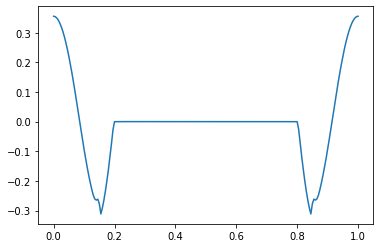

In [38]:
plot(k_dist,evals[nSitios//2-45])